In [1]:
# Copyright (c) 2024 Graphcore Ltd. All rights reserved.

from matplotlib import pyplot as plt
import numpy as np
from gfloat import *
from gfloat.formats import format_info_ocp_e5m2

# Stochastic rounding

This notebook does some simple experiments with stochastic rounding.

The first is to plot the mean rounded value for a relatively small number of bits (2 bits). 

In [2]:
fi = format_info_ocp_e5m2

vs = np.arange(3.1, 6.9, 1 / 117)
# Round to nearest
rn = round_ndarray(fi, vs)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("SR vs SRFast")

for rnd in (RoundMode.Stochastic, RoundMode.StochasticFast):
    ax = ax1 if rnd == RoundMode.Stochastic else ax2
    ax.plot(vs, vs, label="True value", color="k")
    ax.plot(vs, rn, label="Round to nearest", color="orange")

    # Stochastic rounding
    srnumbits = 2
    rvs = np.zeros_like(vs)
    nsamples = 1000
    for n in range(nsamples):
        srbits = np.random.randint(0, 2**srnumbits, vs.shape)
        rvs += [
            round_float(fi, v, rnd, sat=False, srbits=srbits, srnumbits=srnumbits)
            for v, srbits in zip(vs, srbits)
        ]
    rvs /= nsamples
    color = "green" if rnd == RoundMode.Stochastic else "blue"
    ax.plot(vs, rvs, label=f"{rnd}, {srnumbits} bits", color=color)

    ax.set_xlabel("Input float value")
    ax.set_ylabel(f"Average of rounded values, {nsamples} samples")
    ax.set_yticks(np.unique(rn))
    ax.legend()

We can see that, in simple terms, the orange (pale) line is closer to the black line than the (darker) green line.  That is, on average, stochastic rounding preserves accuracy that other roundings do not.  We can also see that the "StochasticFast" mode has a bias, in that rounded values are always above the y=x line, although the accuracy remains better than rounding to nearest.

To visualize the difference between the two modes, this piece of ascii art shows how the SR bits select whether to round down or up based on the input value:

In [ ]:
for rnd in (RoundMode.Stochastic, RoundMode.StochasticFast):
    vs = np.arange(5, 6 + 1 / 64, 1 / 64)
    print(f"SR ", " ".join(f"{v:<7.3f}" for v in np.arange(5, 6.001, 1 / 8)))

    for srbits in range(2**srnumbits):
        r = [
            round_float(fi, v, rnd, sat=False, srbits=srbits, srnumbits=srnumbits)
            for v in vs
        ]
        print(f"{srbits:02b} ", "".join(("_" if r == 5 else "█") for r in r))
    print("")

SR  5.000   5.125   5.250   5.375   5.500   5.625   5.750   5.875   6.000  
00  _________████████████████████████████████████████████████████████
01  _________________________████████████████████████████████████████
10  _________________________________________████████████████████████
11  _________________________________________________________████████

SR  5.000   5.125   5.250   5.375   5.500   5.625   5.750   5.875   6.000  
00  _████████████████████████████████████████████████████████████████
01  _________________████████████████████████████████████████████████
10  _________________________________████████████████████████████████
11  _________________________________________________████████████████



And in non-ascii art:

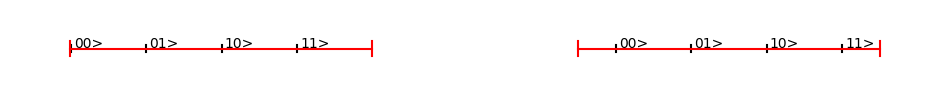

In [ ]:
import matplotlib.patches as patches
import matplotlib.lines as lines
import matplotlib.text

fig, axs = plt.subplots(1, 2, figsize=(12, 1))

for i in (0, 1):
    ax = axs[i]
    ax.set_xlim(-0.2, 1.2)
    ax.set_ylim(-1, 1)

    h = 0.1
    for k in range(4):
        kv = k / 4 + 1 / 8 * i + 0.001
        l = lines.Line2D([kv, kv], [-h, h], color="k")
        ax.add_line(l)
        ax.text(kv + 0.01, 0.01, f"{k:02b}>")

    h = 0.2
    sty = dict(color="r")
    ax.add_line(lines.Line2D([0, 1], [0, 0], **sty))
    ax.add_line(lines.Line2D([0, 0], [-h, h], **sty))
    ax.add_line(lines.Line2D([1, 1], [-h, h], **sty))

    ax.set_axis_off()